In [1]:
import sys
# import pyccl as ccl#
import pickle
import camb
# from importlib import reload

sys.path.insert(0,'/home/tkarim/SkyLens/') #path to skylens
sys.path.insert(0,'/home/tkarim/SkyLens/skylens/') #path to skylens
from skylens import *
from survey_utils import *

In [2]:
ncpu=4
LC,scheduler_info=start_client(Scheduler_file=None,local_directory=None,ncpu=None,n_workers=ncpu,threads_per_worker=1,
                              memory_limit='120gb',dashboard_address=8811,processes=True)
client=client_get(scheduler_info=scheduler_info)

Start_client: No scheduler file, will start local cluster at  ./temp_skylens/pid54787/


In [3]:
wigner_files={} #FIXME: run Gen_wig_m0.py to generate these files and then pass their path here. These are large files, make sure they are not included in git.
# In file names l3500 refers to ell_max for which wigner function was calculated. It should be same or larger than ell_max in your measurements. 
# |w2100 is the max ell for window. This should be atleast 2 X ell_max in the measurements.
wigner_files[0]= '../temp/dask_wig3j_l2048_w4096_0_reorder.zarr/'
# wigner_files[2]= '/Users/Deep/dask_temp/dask_wig3j_l3500_w2100_2_reorder.zarr' #everything is spin 0, should not require this. if needed, compute using Gen_wig_m2.py



# Power Spectrum covariance

In [4]:
#setup parameters
#FIXME: Check all the values below.
lmax_cl=1024 #min and max for ell
lmin_cl=100
l0=np.arange(lmin_cl,lmax_cl)

#following defines the ell bins. Using log bins in example, feel free to change.
lmin_cl_Bins=lmin_cl+10
lmax_cl_Bins=lmax_cl-10
Nl_bins=20
l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
lb=np.sqrt(l_bins[1:]*l_bins[:-1])

l=l0
# l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if computation is too heavy and we want to use fewer ell

do_cov=True # if you want to get covariance. Covariance is slow and this should be false if you are calling skylens inside mcmc.
bin_cl=True #bin the theory and covaraince. 

use_window=True #if you want to include the window effect. Code will return pseudo-cl and pseudo-cl covariance
store_win=True # to store window, for some internal reasons. leave it to true.
window_lmax=200 #smaller value for testing. This should be 2X ell_max in the measurements.

use_binned_l=False  #FIXME: to speed up computation if using pseudo-cl inside mcmc. Needs to be tested. Leave it false for now.

SSV_cov=False # we donot have good model for super sample and tri-spectrum. We can chat about implementing some approximate analytical forms.
tidal_SSV_cov=False
Tri_cov=False 

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)

In [19]:
def cmb_bins_here(zs=1090,l=None,use_window=use_window,unit_win=False,nside=1024,zmax=2.4):
    """
    This function prepares the cmb lensing data into format required for input into skylens for theory predictions.
    """
    zs_bins={}
    zs_bins[0]={}

    zs_bins=zbin_pz_norm(zs_bins=zs_bins,bin_indx=0,zs=np.atleast_1d(zs),p_zs=np.atleast_1d(1),
                         ns=0,bg1=1)
    zs_bins['n_bins']=1 #easy to remember the counts
    zs_bins['zmax']=np.atleast_1d([zmax])
    zs_bins['zp_sigma']=0
    zs_bins['zp_bias']=0
    zs_bins['nz']=0

    SN_read=np.genfromtxt('/mnt/store1/tkarim/cmb_lensing/data/MV/nlkk.dat',names=('l','nl','nl2')) 
#     SN_intp=interp1d(SN_read['l'],SN_read['nl'],bounds_error=False, fill_value=0)      #FIXME: make sure using the correct noise power spectra.
#     SN=SN_intp(l)
    SN=np.ones_like(l) #change... this is for testing. use above lines to read in actual noise
    zs_bins['SN']={}
    zs_bins['SN']['kappa']=SN.reshape(len(SN),1,1)
    if use_window:
        zs_bins=set_window(zs_bins=zs_bins,nside=nside, unit_win=unit_win,cmb=True)
    return zs_bins

In [6]:
def set_window(zs_bins={},nside=1024,mask=None,window_cl_fact=None,unit_win=False,cmb=False):
    """
        This function sets the window functions for the datasets. These windows are necessary for converting cl to pseudo-cl.
    """
    #FIXME: make sure nside, etc. are properly matched. if possible, use same nside for cmb and galaxy maps. Use ud_grade where necessary.
    for i in np.arange(zs_bins['n_bins']):
        if unit_win:
            cl_map=hp.ma(np.ones(12*nside*nside))
            cl_i=1
            mask=np.ones_like(cl_map,dtype='bool')
            mask[nside*nside:]=0
        elif cmb:
            #cl_map=np.load('../desi-lensing-cc/data/elg_ran1024.npy') #FIXME: add the CMB lensing window here.
            cl_map=np.load('/mnt/store1/boryanah/AbacusSummit_base_c000_ph006/light_cones/mask_ring_2048.npy')
        else:
            #cl_map=np.load('../desi-lensing-cc/data/elg_ran1024.npy') #randoms are the window function.
            cl_map=np.load('/mnt/store1/boryanah/AbacusSummit_base_c000_ph006/light_cones/mask_ring_2048.npy')
        cl_map=hp.ma(cl_map)
#             cl_map=hp.alm2map(alms_i,nside=nside)
        if mask is None:
            mask=cl_map>0 #FIXME: input proper mask if possible
        cl_map.mask=~mask
        cl_map[cl_map<0]=0
        cl_map/=cl_map[mask].mean()
        cl_map_noise=np.sqrt(cl_map)
        cl_map[~mask]=hp.UNSEEN
        cl_map_noise[~mask]=hp.UNSEEN
        # cl_map.mask=mask
        zs_bins[i]['window']=cl_map
        zs_bins[i]['window_alm']=hp.map2alm(cl_map)
        zs_bins[i]['window_alm_noise']=hp.map2alm(cl_map_noise)
#         zs_bins[i]['window_cl']=cl_i

    return zs_bins

In [7]:
def zbin_pz_norm(zs_bins={},bin_indx=None,zs=None,p_zs=None,ns=0,bg1=1,AI=0,
                 AI_z=0,mag_fact=0,k_max=0.3):
    """
        This function does few pre-calculations and sets some parameters for datasets that will be input into skylens
    """


    dzs=np.gradient(zs) if len(zs)>1 else 1

    if np.sum(p_zs*dzs)!=0:
        p_zs=p_zs/np.sum(p_zs*dzs)
    else:
        p_zs*=0
    nz=dzs*p_zs*ns

    i=bin_indx
    x= p_zs>-1 #1.e-10

    zs_bins[i]['z']=zs[x]
    zs_bins[i]['dz']=np.gradient(zs_bins[i]['z']) if len(zs_bins[i]['z'])>1 else 1
    zs_bins[i]['nz']=nz[x]
    zs_bins[i]['ns']=ns
    zs_bins[i]['W']=1.
    zs_bins[i]['pz']=p_zs[x]*zs_bins[i]['W']
    zs_bins[i]['pzdz']=zs_bins[i]['pz']*zs_bins[i]['dz']
    zs_bins[i]['Norm']=np.sum(zs_bins[i]['pzdz'])
    zs_bins[i]['b1']=bg1 # FIXME: this is the linear galaxy bias. Input proper values. We can also talk about adding other bias models if needed.
    zs_bins[i]['AI']=AI # this will be zero
    zs_bins[i]['AI_z']=AI_z
    zs_bins[i]['mag_fact']=mag_fact  #FIXME: You need to figure out the magnification bias prefactor. For example, see appendix B of https://arxiv.org/pdf/1803.08915.pdf
    zm=np.sum(zs_bins[i]['z']*zs_bins[i]['pzdz'])/zs_bins[i]['Norm']
    zs_bins[i]['lm']=k_max*cosmo_h.comoving_transverse_distance(zm).value
    return zs_bins

In [8]:
def source_tomo_bins(zp=None,p_zp=None,nz_bins=None,ns=26,ztrue_func=None,zp_bias=None,
                    zp_sigma=None,zs=None,n_zs=100,z_bins=None,f_sky=0.3,nside=256,use_window=False,
                    mask_start_pix=0,window_cl_fact=None,bg1=1,AI=0,AI_z=0,l=None,mag_fact=0,
                     sigma_gamma=0.26,k_max=0.3,unit_win=False,use_shot_noise=True,**kwargs):
    """
        Setting galaxy redshift bins in the format used in skylens code.
        Need
        zs (array): redshift bins for every source bin. if z_bins is none, then dictionary with
                    with values for each bin
        p_zs: redshift distribution. same format as zs
        z_bins: if zs and p_zs are for whole survey, then bins to divide the sample. If
                tomography is based on lens redshift, then this arrays contains those redshifts.
        ns: The number density for each bin to compute shape noise.
    """
    zs_bins={}

    if nz_bins is None:
        nz_bins=1

    if z_bins is None:
        z_bins=np.linspace(min(zp)-0.0001,max(zp)+0.0001,nz_bins+1)
    if zs is None:
        zs=np.linspace(0,max(z_bins)+1,n_zs)
    dzs=np.gradient(zs)
    dzp=np.gradient(zp) if len(zp)>1 else [1]
    zp=np.array(zp)

    zl_kernel=np.linspace(0,max(zs),50)
    lu=Tracer_utils() #Change
    cosmo_h=cosmo_h_PL

    zmax=max(z_bins)

    l=[1] if l is None else l
    zs_bins['SN']={}
    zs_bins['SN']['galaxy']=np.zeros((len(l),nz_bins,nz_bins))
    zs_bins['SN']['shear']=np.zeros((len(l),nz_bins,nz_bins))
    zs_bins['SN']['kappa']=np.zeros((len(l),nz_bins,nz_bins))

    for i in np.arange(nz_bins):
        zs_bins[i]={}
        indx=zp.searchsorted(z_bins[i:i+2])

        if indx[0]==indx[1]:
            indx[1]=-1
        zs=zp[indx[0]:indx[1]]
        p_zs=p_zp[indx[0]:indx[1]]
        nz=ns*p_zs*dzp[indx[0]:indx[1]]
        ns_i=nz.sum()

        zs_bins=zbin_pz_norm(zs_bins=zs_bins,bin_indx=i,zs=zs,p_zs=p_zs,ns=ns_i,bg1=bg1,
                             AI=AI,AI_z=AI_z,mag_fact=mag_fact,k_max=k_max)
        
        zmax=max([zmax,max(zs_bins[i]['z'])])
        if use_shot_noise:
            zs_bins['SN']['galaxy'][:,i,i]=galaxy_shot_noise_calc(zg1=zs_bins[i],zg2=zs_bins[i])
            zs_bins['SN']['shear'][:,i,i]=shear_shape_noise_calc(zs1=zs_bins[i],zs2=zs_bins[i],
                                                                 sigma_gamma=sigma_gamma)
            zs_bins['SN']['kappa'][:,i,i]=shear_shape_noise_calc(zs1=zs_bins[i],zs2=zs_bins[i],
                                                                 sigma_gamma=sigma_gamma) #FIXME: This is almost certainly not correct

    zs_bins['n_bins']=nz_bins #easy to remember the counts
    zs_bins['z_lens_kernel']=zl_kernel
    zs_bins['zmax']=zmax
    zs_bins['zp']=zp
    zs_bins['pz']=p_zp
    zs_bins['z_bins']=z_bins
    zs_bins['zp_sigma']=zp_sigma
    zs_bins['zp_bias']=zp_bias
    if use_window:
        zs_bins=set_window(zs_bins=zs_bins,nside=nside, unit_win=unit_win)
    return zs_bins

In [9]:
def DESI_elg_bins(nz_bins=1, f_sky=0.3,nside=256,use_window=use_window,mask_start_pix=0,bg1=1,
                       l=None,sigma_gamma=0,mag_fact=0,z_bins=None,**kwargs):

    home='../desi-lensing-cc/data/'
    fname='dNdz'
    t=np.genfromtxt(home+fname,names=True)
    dz=t['z'][1]-t['z'][0]
    zmax=max(t['z'])+dz/2
    zmin=min(t['z'])-dz/2

    z=t['z']
    
    pz=t['dNdzddeg2']
    
    ns=np.sum(pz)
    ns/=d2r**2 #convert from deg**2 to rd**2

    if z_bins is None: #this defines the bin edges if splitting the sample into bins. Preferably pass it as an argument whenusing multiple bins.
        z_bins=np.linspace(zmin, min(2,zmax), nz_bins+1)
    print(zmin,zmax,z_bins,ns)
    return source_tomo_bins(zp=z,p_zp=pz,ns=ns,nz_bins=nz_bins,mag_fact=mag_fact,
                            ztrue_func=None,zp_bias=0,
                            zp_sigma=0,z_bins=z_bins,f_sky=f_sky,nside=nside,
                            use_window=use_window,mask_start_pix=mask_start_pix,bg1=bg1,
                            l=l,sigma_gamma=sigma_gamma,**kwargs)

#Change... following function is defined for testing
import scipy
def DESI_elg_bins_test(nz_bins=1, f_sky=0.3,nside=256,use_window=use_window,mask_start_pix=0,bg1=1,
                       l=None,sigma_gamma=0,mag_fact=0,z_bins=None,**kwargs):
    
    z=np.linspace(0.5,1,6)
#     home='../desi-lensing-cc/data/'
#     fname='dNdz'
#     t=np.genfromtxt(home+fname,names=True)
    t={}
    t['z']=0.5*(z[1:]+z[:-1])
    t['dNdzddeg2']=scipy.stats.norm.pdf(z,loc=.7,scale=0.1)
    dz=t['z'][1]-t['z'][0]
    zmax=max(t['z'])+dz/2
    zmin=min(t['z'])-dz/2

    z=t['z']
    
    pz=t['dNdzddeg2']
    
    ns=np.sum(pz)
    ns/=d2r**2 #convert from deg**2 to rd**2

    if z_bins is None: #this defines the bin edges if splitting the sample into bins. Preferably pass it as an argument whenusing multiple bins.
        z_bins=np.linspace(zmin, min(2,zmax), nz_bins+1)
    print(zmin,zmax,z_bins,ns)
    return source_tomo_bins(zp=z,p_zp=pz,ns=ns,nz_bins=nz_bins,mag_fact=mag_fact,
                            ztrue_func=None,zp_bias=0,unit_win=True,
                            zp_sigma=0,z_bins=z_bins,f_sky=f_sky,nside=nside,
                            use_window=use_window,mask_start_pix=mask_start_pix,bg1=bg1,
                            l=l,sigma_gamma=sigma_gamma,**kwargs)

In [10]:
zl_bin=DESI_elg_bins_test()

0.5000000000000001 0.9999999999999999 [0.5 1. ] 32673.689888612906
Tracer utils has no tracers


In [11]:
zl_bin.keys()

dict_keys(['SN', 0, 'n_bins', 'z_lens_kernel', 'zmax', 'zp', 'pz', 'z_bins', 'zp_sigma', 'zp_bias'])

In [12]:
zl_bin[0].keys()

dict_keys(['z', 'dz', 'nz', 'ns', 'W', 'pz', 'pzdz', 'Norm', 'b1', 'AI', 'AI_z', 'mag_fact', 'lm', 'window', 'window_alm', 'window_alm_noise'])

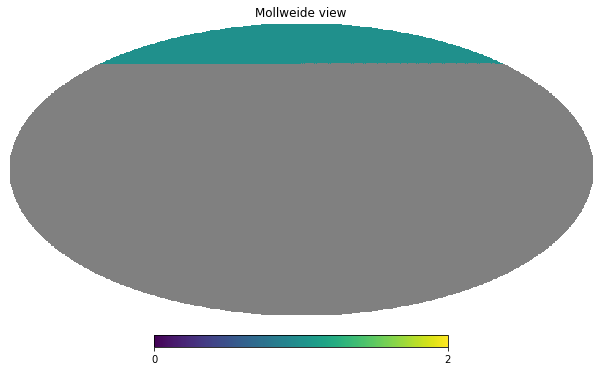

In [13]:
if use_window:
    hp.mollview(zl_bin[0]['window'])

In [14]:
zl_bin[0]['window']

masked_array(data=[1.0, 1.0, 1.0, ..., -1.6375e+30, -1.6375e+30,
                   -1.6375e+30],
             mask=[False, False, False, ..., False, False, False],
       fill_value=-1.6375e+30)

[]

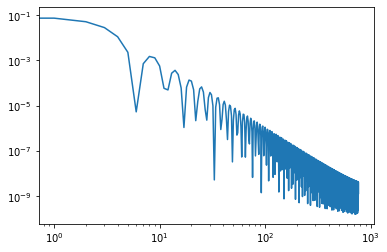

In [17]:
import matplotlib.pyplot as plt
window_cl=hp.anafast(zl_bin[0]['window'])
plt.plot(window_cl)
plt.loglog()

In [20]:
zs_bin=cmb_bins_here(l=l,unit_win=True)# lensing source bin
#Change: set unit_win=False to use the right window.

In [21]:
store_win=True

In [22]:
f_sky=0.35 #FIXME: use the correct value. If you are using window, then this is not very important.

In [23]:
corr_ll=('kappa','kappa')
corr_gg=('galaxy','galaxy')
corr_gl=('galaxy','kappa')
corrs=[corr_ll,corr_gg,corr_gl]

In [24]:
#use all ell
#Change: name changes: zk_bins->kappa_zbins, zl_bins->galaxy_zbins
kappa0=Skylens(kappa_zbins=zs_bin,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, galaxy_zbins=zl_bin,
                                       use_window=use_window,Tri_cov=Tri_cov,
                                       use_binned_l=use_binned_l,wigner_files=wigner_files,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
                                       store_win=store_win,window_lmax=window_lmax,
                                       corrs=corrs,stack_indxs=None,corr_indxs=None)

Tracer utils has tracers:  ['galaxy', 'kappa']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 2.415
power spectra camb_pk_too_many_z
Win gen: step size 92 924 201.0 10
wigner_files: {0: '../temp/dask_wig3j_l2048_w4096_0_reorder.zarr/'}
wigner done dict_keys([])
set window_cl: cl0,cl_b done 7.104873657226562e-05
set window_cl: cl done 13.029669284820557 561.737 0.0
Win_cli ('kappa', 'kappa', 0, 0) ('kappa', 'kappa') (0, 0)
Win_cli ('galaxy', 'galaxy', 0, 0) ('galaxy', 'galaxy') (0, 0)
Win_cli ('galaxy', 'kappa', 0, 0) ('galaxy', 'kappa') (0, 0)
set window_cl: cl done 13.849996566772461 561.737 0.0
cl+cov bags done 3 6 14.63149094581604


KeyboardInterrupt: 

In [ ]:
%time cl0G=kappa0.cl_tomo() 

In [ ]:
cl0G.keys()

In [ ]:
dask.visualize(cl0G['stack'])

In [ ]:
bi=(0,0) #z_bin indexes
plot(cl0G['cl_b'][corr_ll][bi].compute())

In [ ]:
%time cl0=cl0G['stack'].compute()

In [ ]:
cl0